# Near axis constraints

This tutorial shows how to find equilibrium solutions in DESC which are constrained to have the same axis and near-axis behavior as a NAE solution from the pyQSC or pyQIC codes

## Creating a DESC Equilibrium from a pyQSC or pyQIC Near-Axis Equilibrium

Note that you must have pyQSC and/or pyQIC installed in order to make use of the `Equilibrium.from_near_axis` method. 
You can do so with `pip install qsc`. 

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
# must have installed pyQsc with `pip install qsc` in order to use this!
from qsc import Qsc
import numpy as np
import matplotlib.pyplot as plt
from desc.equilibrium import Equilibrium
from desc.objectives import get_fixed_boundary_constraints
from desc.plotting import (
    plot_comparison,
    plot_fsa,
    plot_section,
    plot_surfaces,
    plot_qs_error,
)

DESC version 0.10.3+295.g453276a3.dirty,using JAX backend, jax version=0.4.13, jaxlib version=0.4.13, dtype=float64
Using device: CPU, with 12.81 GB available memory


DESC is able to create an equilibrium based off of a `pyQsc` NAE equilibrium object. First, we'll make the NAE equilibrium using `pyQsc`

In [3]:
qsc_eq = Qsc.from_paper("precise QA")

Then, to make the DESC equilibrium, the `Equilibrium` class has a method `Equilibrium.from_near_axis`. This method creates a DESC `Equilibrium` based off of the `pyQsc` equilibrium. It requires as input the desired DESC Fourier-Zernike resolutions, as well as the radius at which you want to evaluate the qsc equilibrium at to make the DESC equilibrium's boundary. The equilibrium's initial `R_lmn`, `Z_lmn` Fourier-Zernike coefficients are fit to the `R,Z` evaluated from the `Qsc` equilibrium, and the initial `L_lmn` are 0 (because the `Qsc` equilibrium uses Boozer angles, so there is no poloidal stream function)

In [4]:
# ntheta is the number of points in theta to sample
# when fitting the DESC Fourier-Zernike basis to
# the NAE surfaces.
# The more shaped the NAE surfaces, the higher this should be,
# 75 is a good minimum value.
ntheta = 75
# r is the finite radius to evaluate the NAE surfaces at, this will
# roughly set the aspect ratio of the resulting solution.
# However if this is too large, the surfaces from the NAE may become
# self-intersecting! The r at which this occurs varies for different NAE
# solutions, r=0.35 was found to be a reasonable radius for precise QA
r = 0.35
desc_eq = Equilibrium.from_near_axis(
    qsc_eq,  # the Qsc equilibrium object
    r=r,  # the finite radius (m) at which to evaluate the Qsc surface to use as the DESC boundary
    L=8,  # DESC radial resolution
    M=8,  # DESC poloidal resolution
    N=8,  # DESC toroidal resolution
    ntheta=ntheta,
)
eq_fit = desc_eq.copy()  # copy so we can see the original Qsc surfaces later

Now we solve the equilibrium as normal in DESC

In [5]:
# get the fixed-boundary constraints, which include also fixing the pressure and fixing the current profile (iota=False flag means fix current)
constraints = get_fixed_boundary_constraints(eq=desc_eq)
for c in constraints:
    print(c)

# solve the equilibrium
desc_eq.solve(
    verbose=3,
    ftol=1e-2,
    objective="force",
    maxiter=100,
    xtol=1e-6,
    constraints=constraints,
)

# Save equilibrium as .h5 file
desc_eq.save("DESC_from_NAE_precise_QA_output.h5")

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.52 sec
Timer: Objective build = 8.20 sec
Timer: Linear constraint projection build = 10.1 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 3.86 sec
Timer: Jacobian compilation time = 12.0 sec
Timer: Total compilation time = 15.9 sec
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.079e+01                                    1.241e+04   
       1              2          2.355e+00      1.844e+01      3.138e-01      1.297e+03   
       2              3          5.777e-02      2.297e+00      1.514e-01      3.875e+02   
       3              4          9.046e-03      4.872e-02      1.865e-01      5.217e+01   
       4              6          1.395e-03      7.652e-03      4.553e-02      2.3

Now we have a DESC equilibrium solved with the boundary from `Qsc`. It has zero toroidal current as its profile constraint along with zero pressure since the original `Qsc` equilibrium had no pressure or current.

However, if we plot the surfaces, we see that while the boundary matches, the interior deviates slightly from the NAE, especially near the core. This means we may have lost some of the optimized properties from the QSC equilibrium.

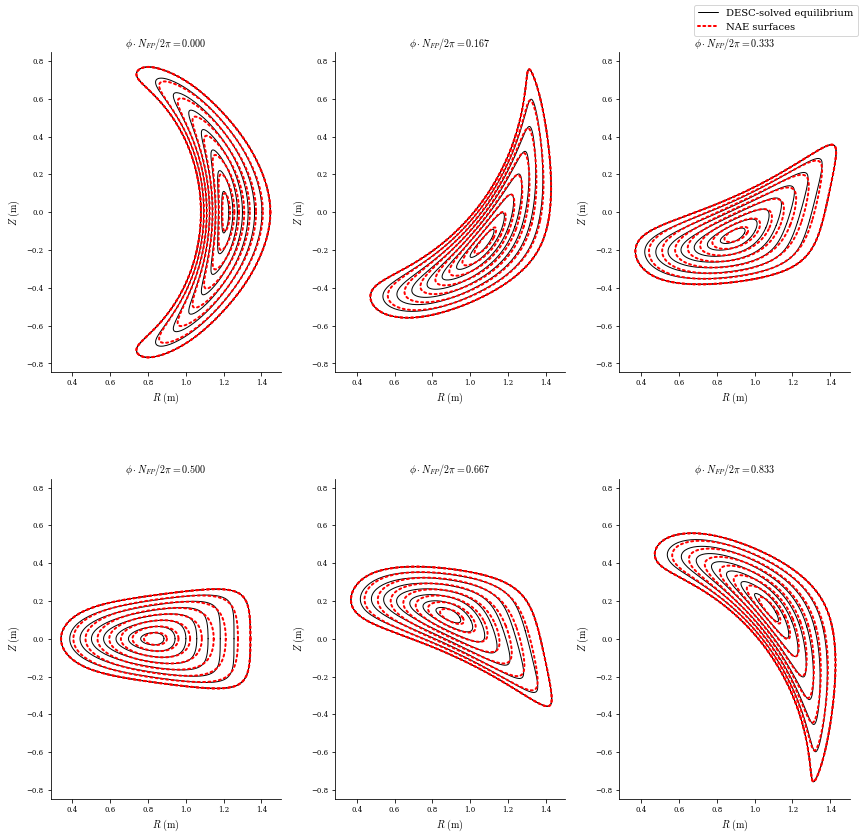

In [6]:
plot_comparison(
    eqs=[desc_eq, eq_fit],
    labels=["DESC-solved equilibrium", "NAE surfaces"],
    figsize=(12, 12),
    theta=0,
    color=["k", "r"],
    ls=["-", ":"],
    lw=[1, 2],
);

Instead of evaluating the NAE at a finite radius, fixing that boundary, and hoping the axis behavior stays the same, we can instead directly fix the axis and the $O(\rho)$ asymptotic behavior.

## Solving Equilibria with Fixed Axis and Fixed NAE $O(\rho)$ Behavior in DESC

In [13]:
# utility functions for getting the NAE constraints
from desc.objectives import (
    get_equilibrium_objective,
    get_NAE_constraints,
    FixAxisR,
    FixAxisZ,
    FixNearAxisR,
    FixNearAxisZ,
    FixPressure,
    FixCurrent,
    FixPsi,
)

eq_NAE = eq_fit.copy()
# the constraints we want are:
constraints = (
    FixAxisR(eq_NAE),
    FixAxisZ(eq_NAE),
    FixNearAxisR(eq_NAE, qsc_eq, order=1),
    FixNearAxisZ(eq_NAE, qsc_eq, order=1),
    FixPressure(eq_NAE),
    FixCurrent(eq_NAE),
    FixPsi(eq_NAE),
)

# Alternatively, we can use the util function: 
constraints = get_NAE_constraints(eq_NAE, qsc_eq, order=1)
for c in constraints:
    print(c)


eq_NAE.solve(
    verbose=3,
    ftol=1e-2,
    objective="force",
    maxiter=50,
    xtol=1e-6,
    constraints=constraints,
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 423 ms
Timer: Objective build = 1.24 sec
Timer: Linear constraint projection build = 5.05 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 3.82 sec
Timer: Jacobian compilation time = 11.8 sec
Timer: Total compilation time = 15.7 sec
Number of parameters: 1094
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.084e+01                                    8.055e+03   
       1              3          1.269e+01      8.153e+00      2.157e-01      1.983e+04   
       2              4          6.743e-01      1.202e+01      1.194e-01      1.470e+03   
       3              5          1.259e-01      5.484e-01      2.337e-01      1.815e+02   
       4              7          9.821e-03      1.161e-01      7.469e-02      4.62

## Comparing near axis behavior

Again we can plot the surfaces, and we see that in this case, the near axis behavior is preserved, while the outer surfaces differ. This is expected, as the NAE from QSC is only valid asymptotically near the axis. By constraining this behavior we are able to keep all the desireable properties of the NAE where they are valid without overly constraining the problem.

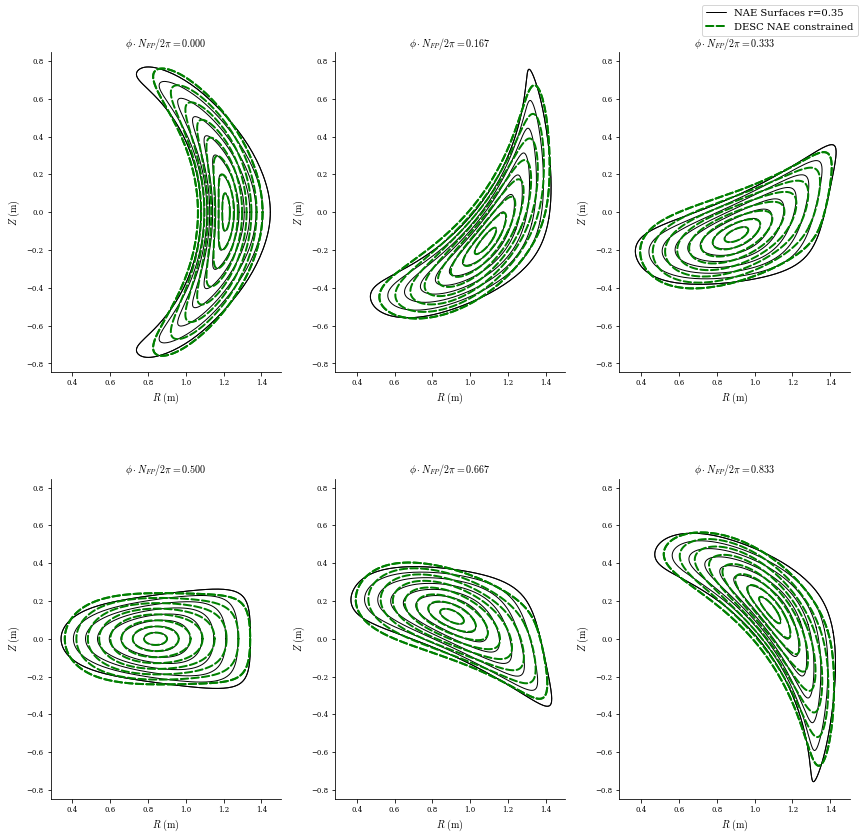

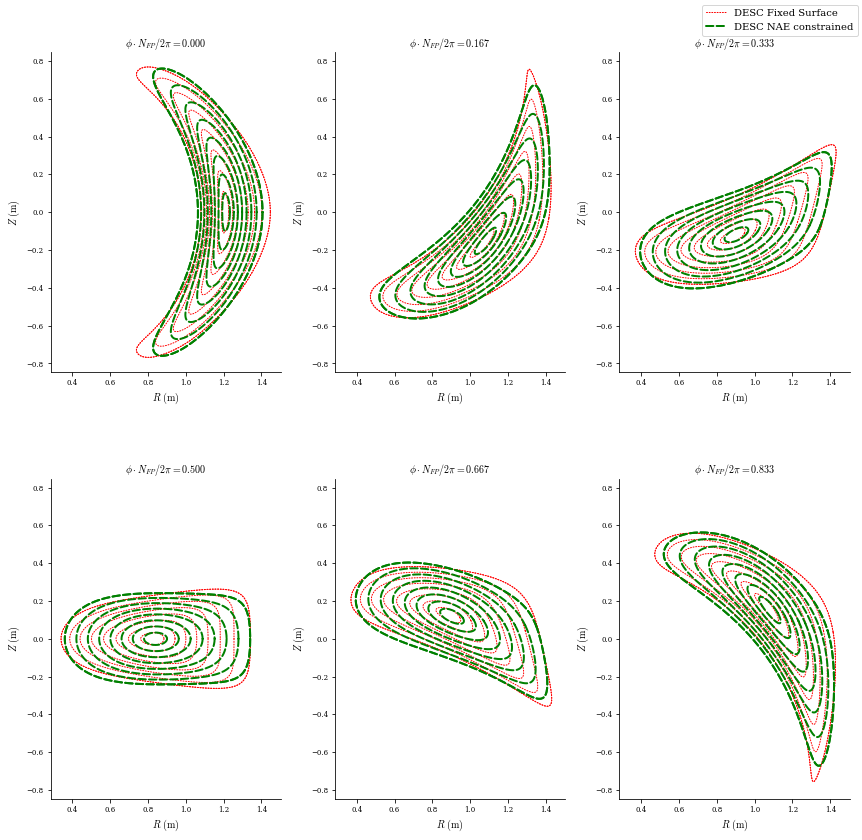

In [8]:
fig, ax = plot_comparison(
    eqs=[eq_fit, eq_NAE],
    labels=[f"NAE Surfaces r={r}", f"DESC NAE constrained"],
    color=["k", "g"],
    ls=["-", "--"],
    figsize=(12, 12),
    theta=0,
    lw=[1, 2],
)
fig, ax = plot_comparison(
    eqs=[desc_eq, eq_NAE],
    labels=[f"DESC Fixed Surface", f"DESC NAE constrained"],
    color=["r", "g"],
    ls=[":", "--"],
    figsize=(12, 12),
    theta=0,
    lw=[1, 2],
);

As a final comparison, we can plot the QS error for the fixed boundary and fixed NAE solves. We see that by fixing the NAE behavior, we are able to preserve the QS from the original QSC equilibrium.

Text(0, 0.5, '$f_B$')

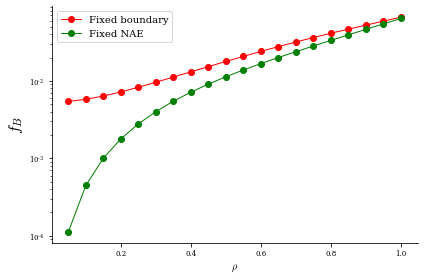

In [9]:
fix, ax = plt.subplots()
plot_qs_error(
    desc_eq,
    fC=False,
    fT=False,
    log=True,
    ax=ax,
    color=["r"],
    legend=False,
    labels=["Fixed boundary"],
    figsize=(8, 8),
)
plot_qs_error(
    eq_NAE,
    fC=False,
    fT=False,
    log=True,
    ax=ax,
    color=["g"],
    legend=False,
    labels=["Fixed NAE"],
)
ax.legend()
ax.set_ylabel(
    "$f_B$", fontsize=16
)  # f_B = sqrt(sum(symmetry-breaking modes**2)) / sqrt(sum(all modes**2))

The correct behaviour near the axis may be also checked by assessing directly other features of the equilibrium; most notably, the behaviour of |B| on axis, the rotational transform on axis, as well as the form of $\lambda$. Starting from the rotational transform, we may compare the values obtained in the equilibrium to those of the near-axis expansion. 

Relative error in the rotational transform (fixed NAE):  -2.6032466647805142e-05
Relative error in the rotational transform (fixed surface):  0.11412206021844867


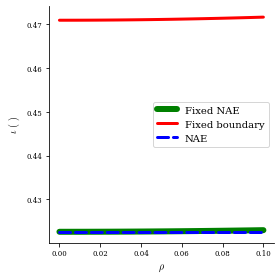

In [10]:
import matplotlib.pyplot as plt
from desc.plotting import plot_fsa

rho = np.linspace(0, 1e-1)
fig, ax, iota_nae = plot_fsa(
    eq_NAE, "iota", rho=rho, return_data=True, lw=6, linecolor="g"
)
fig, ax, iota_surf = plot_fsa(
    desc_eq, "iota", rho=rho, ax=ax, return_data=True, linecolor="r", lw=3
)
plt.plot(rho, np.ones(np.size(rho)) * qsc_eq.iota, linestyle="--", lw=3, c="b")
plt.legend(["Fixed NAE", "Fixed boundary", "NAE"])
print(
    "Relative error in the rotational transform (fixed NAE): ",
    (iota_nae["iota"][0] - qsc_eq.iota) / qsc_eq.iota,
)
print(
    "Relative error in the rotational transform (fixed surface): ",
    (iota_surf["iota"][0] - qsc_eq.iota) / qsc_eq.iota,
)
# print(iota[1].yaxis)

This clearly shows that the constraint is working as it is intended. A similar expected behaviour can be found for other features of the equilibrium such as the magnetic field on axis.

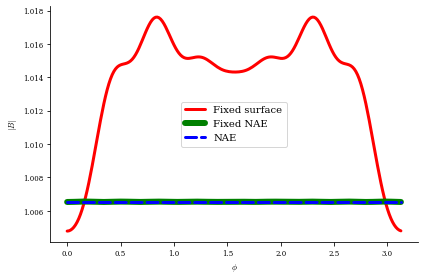

In [11]:
from desc.compute import data_index
from desc.grid import LinearGrid

grid = LinearGrid(theta=np.array(0.0), N=100, NFP=desc_eq.NFP, rho=np.array(0.0))
# Evaluate B modes near the axis
data_surf = desc_eq.compute(["|B|"], grid=grid)
data_nae = eq_NAE.compute(["|B|"], grid=grid)
phi = grid.nodes[:, 2]

plt.plot(phi, data_surf["|B|"], lw=3, c="r")
plt.plot(phi, data_nae["|B|"], lw=6, c="g")
plt.plot(phi, np.ones(np.size(phi)) * qsc_eq.B0, linestyle="--", lw=3, c="b")
plt.xlabel("$\phi$")
plt.ylabel("$|B|$")
plt.legend(["Fixed surface", "Fixed NAE", "NAE"])
plt.show()

Finally, we may check $\lambda$ on axis and compare it to $\nu$ from within the near-axis expansion.

$\lambda$ is the poloidal stream function used in DESC which transforms the computational poloidal angle $\theta$ into the straight-field-line (SFL) poloidal angle  $\theta_{PEST} = \theta + \lambda$ (So B is "straight" when plotted in this poloidal angle and the cylindrical toroidal angle $\phi$).

Now, the NAE describes flux surfaces using the Boozer poloidal angle $\theta_B$, and we are constraining our solution to be asymptotically equivalent to the NAE, so our computational poloidal angle on-axis should approach $\theta = \theta_B$. 

We also know that $\theta_{PEST} = \theta_B - \iota \nu$ where $\nu = \phi_B - \phi$, with $\phi_B$ being the Boozer toroidal angle.

Taken together with $\theta_{PEST} = \theta + \lambda$, we find that on-axis we expect our DESC NAE-constrained solution to have $\lambda = -\iota \nu$, where $\nu$ is known already from the NAE.

Deviation of theta from Boozer angle (fixed surface) 0.09930226593202805
Deviation of theta from Boozer angle (fixed nae) 5.0166543481847925e-05


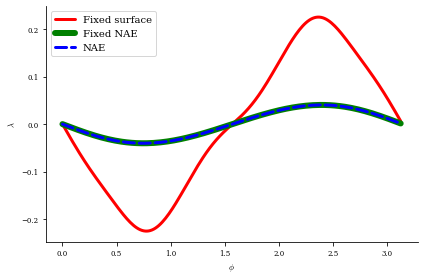

In [12]:
# Evaluate lambda at the axis
data_surf = desc_eq.compute("lambda", grid=grid)
data_nae = eq_NAE.compute("lambda", grid=grid)
lam_surf = data_surf["lambda"]
lam_nae = data_nae["lambda"]

print(
    "Deviation of theta from Boozer angle (fixed surface)",
    np.mean(np.abs(lam_surf + qsc_eq.iota * qsc_eq.nu_spline(phi))),
)
print(
    "Deviation of theta from Boozer angle (fixed nae)",
    np.mean(np.abs(lam_nae + qsc_eq.iota * qsc_eq.nu_spline(phi))),
)
plt.plot(phi, lam_surf, lw=3, c="r")
plt.plot(phi, lam_nae, lw=6, c="g")
plt.plot(phi, -qsc_eq.iota * qsc_eq.nu_spline(phi), linestyle="--", lw=3, c="b")
plt.xlabel("$\phi$")
plt.ylabel("$\lambda$")
plt.legend(["Fixed surface", "Fixed NAE", "NAE"])
plt.show()

The above comparison shows that the DESC equilibrium constructed with the near-axis constraint is consistent with the near-axis behaviour.